In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
data = pd.read_csv('/Users/enrikasoucy/Downloads/archive (13)/INCART 2-lead Arrhythmia Database.csv')

In [4]:
subset_fraction = 0.1
data_subset = data.sample(frac=subset_fraction, random_state=42)

In [6]:
type_mapping = {
    'N': 'Normal',
    'SVEB': 'Abnormal',
    'VEB': 'Abnormal',
    'F': 'Abnormal',
    'Q': 'Abnormal'
}
data_subset['type'] = data_subset['type'].map(type_mapping)

In [7]:
type_counts = data_subset['type'].value_counts()

In [8]:
binary_type_names = {
    'Normal': 'Normal',
    'Abnormal': 'Abnormal'
}

print("Counts of Each Type:")
for type_code, count in type_counts.items():
    print(f"{binary_type_names[type_code]}: {count}")

Counts of Each Type:
Normal: 15291
Abnormal: 2282


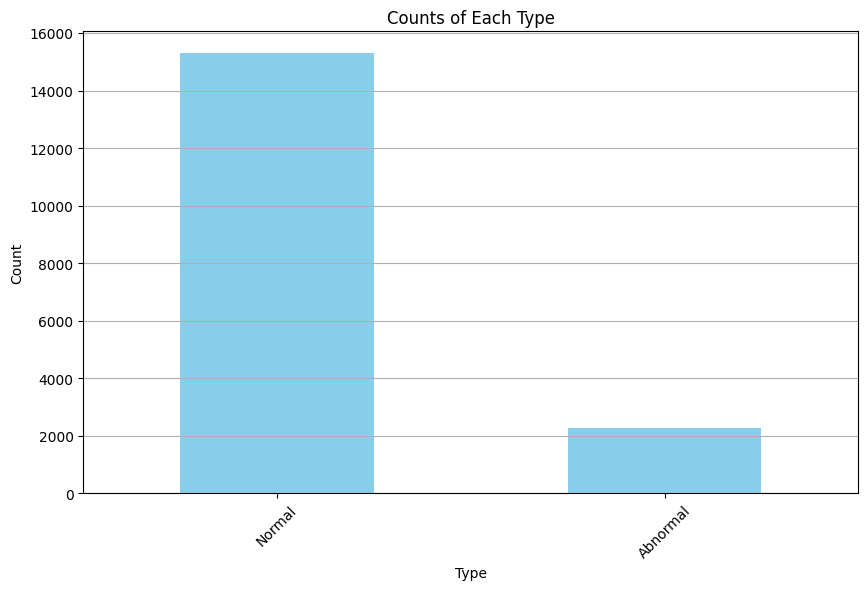

In [9]:
type_counts.index = type_counts.index.map(binary_type_names)

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [10]:
data_subset = data_subset.drop(columns=['record'])

In [11]:
data_subset.head()

,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
127003,Normal,207,116,-0.271953,-0.581058,1.159358,-0.969211,-0.283819,18,3,...,-0.092437,5,5,19,9,-0.092437,-0.235143,-0.390789,-0.541035,-0.659099
42375,Normal,132,129,-0.062590,-0.165819,1.064046,-0.661974,-0.083663,16,5,...,-0.112104,18,8,35,9,-0.112104,-0.106871,-0.055238,0.098790,-0.329881
174362,Normal,261,213,0.023637,0.908885,-0.227999,-0.227999,-0.711413,3,9,...,-0.146879,4,3,23,16,-0.146879,-0.146879,-0.448174,-0.722754,-0.912820
9502,Normal,172,170,-0.021703,0.159623,-0.018327,-0.018327,-0.064718,2,5,...,-0.086555,5,3,25,17,-0.086555,-0.218276,-0.364151,-0.500625,-0.603351
149736,Abnormal,251,299,0.001921,0.926707,-1.034751,-1.237492,-1.034751,3,18,...,-0.128392,8,20,42,14,-0.128392,-0.142729,-0.207564,-0.257827,-0.359538


In [12]:
X = data_subset.drop('type', axis=1)
y = data_subset['type']

In [13]:
binary_type_mapping = {'Normal': 0, 'Abnormal': 1}
y = y.map(binary_type_mapping)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [15]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [17]:
subset_size = 1000
X_train_subsample = X_train_resampled[:subset_size]
y_train_subsample = y_train_resampled[:subset_size]

In [19]:
base_estimator = RandomForestClassifier(random_state=101)
model = BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=101)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_subsample, y_train_subsample, cv=cv, scoring='accuracy')
print("Cross-val scores: ", scores)
print("Avg cross-val score: ", scores.mean())

Cross-val scores:  [0.975 0.985 0.97  0.98  0.99 ]
Avg cross-val score:  0.9799999999999999


In [22]:
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'n_estimators': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_subsample, y_train_subsample)

print("Best params: ", grid_search.best_params_)
print("Best cross-val score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
best_model.fit(X_train_subsample, y_train_subsample)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("*** Confusion Matrix ***")
print(confusion_matrix(y_test, y_pred))
print("*** Classification Report ***")
print(classification_report(y_test, y_pred, target_names=list(binary_type_names.values())))

Best params:  {'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200, 'n_estimators': 20}
Best cross-val score:  0.9810000000000001
Accuracy: 0.9795163584637269
*** Confusion Matrix ***
[[3054    5]
 [  67  389]]
*** Classification Report ***
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99      3059
    Abnormal       0.99      0.85      0.92       456

    accuracy                           0.98      3515
   macro avg       0.98      0.93      0.95      3515
weighted avg       0.98      0.98      0.98      3515



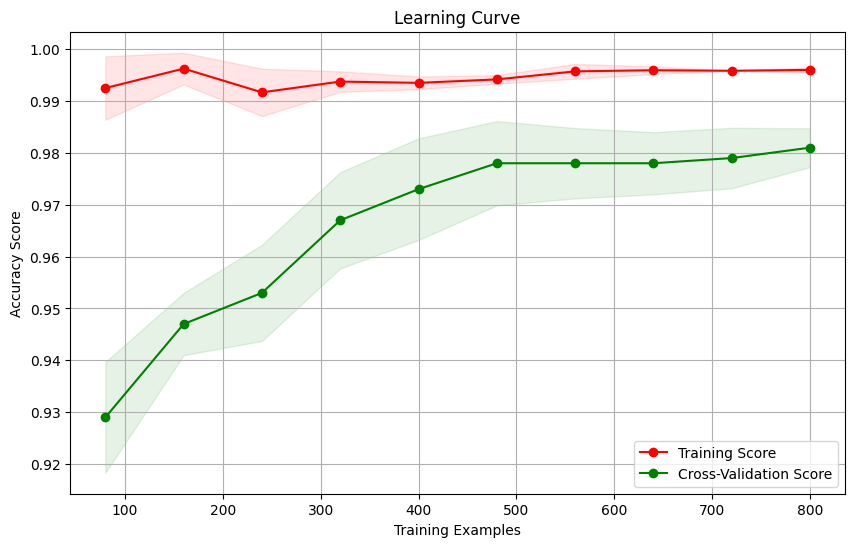

In [23]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_subsample, y_train_subsample, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()